In [4]:
from transformers import pipeline
from datasets import load_dataset
from numpy import average, round, mean
import pandas as pd
import re
import xlwings as xw
import swifter
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

#### Métrica

In [5]:
def create_results_list(data, answers, num_iterations):
    """
    Create a results list based on whether each corresponding answer is present in the corresponding sublist of the data.

    Parameters:
    - data: List of sublists to search through
    - answers: List of answers to check for in each sublist
    - num_iterations: Number of iterations to consider for each sublist

    Returns:
    - results_list: List of 1s and 0s based on the presence of answers in the sublists

    results_list = []
    for sublist, answer in zip(data, answers):
        results_list.append(1 if answer in sublist[:num_iterations] else 0)
    """
    results_list = [1 if answer in sublist[:num_iterations] else 0 for sublist, answer in zip(data, answers)]
    return results_list, round(average(results_list),3)



def process_prompt_results(df_column, masked_model):
    """
    Process the results of prompts and return outputs, indices of passed prompts, and indices of failed prompts.
    The if statement checks that the masked_model function returns 10 outputs.
    This was used because some outputs in the template have a list within the list and therefore
    it is not possible to extract the values from the token_str key. If this happens, the outputs
    will be stored in a list and the index will be stored in the list in the indices_pass list.
    Otherwise, the index will be stored in the indices_notPass list.

    Parameters:
    df_column (pandas.Series): The column containing the prompts.
    masked_model (transformers.FillMaskPipeline): The function that takes a prompt as input and returns a list of dictionaries.

    Returns:
    outputs (list): A list of lists containing the best outputs for each prompt.
    indices_pass (list): A list of indices of prompts that passed the condition.
    indices_notPass (list): A list of indices of prompts that did not pass the condition.
    """
    outputs = []
    indices_pass = []
    indices_notPass = []

    # Iterate through prompts and store the best output
    for index, prompt in enumerate(df_column):
        if len(masked_model(prompt)) == 10:
            outputs.append(
                [dictionary['token_str'].strip().lower() for dictionary in masked_model(prompt)]
            )
            indices_pass.append(index)
        else:
            indices_notPass.append(index)

    return outputs, indices_pass, indices_notPass

def process_prompt_results2(df_column, masked_model):
    """
    Process the results of prompts using a masked language model.

    Parameters:
    df_column (list): A list of prompts to be processed.
    masked_model: The masked language model used for processing.

    Returns:
    list: A list of outputs for each prompt, where each output is a list of token strings.
    """
    outputs = []

    # Iterate through prompts and store the best output
    for prompt in df_column:
        outputs.append(
            [dictionary['token_str'].strip().lower() for dictionary in masked_model(prompt)]
            )
    return outputs


def mask_substitution(text):
    """
    Replace '[MASK]' with '<mask>' in the input text.

    Parameters:
    - text: Input text

    Returns:
    - Transformed text
    """
    return re.sub(r'\[MASK\]', '<mask>', text)


#### Dataframe

In [11]:
google_re = load_dataset("lama", 'trex') #['conceptnet', 'google_re', 'squad', 'trex']
google = pd.DataFrame(google_re["train"])
#google = google[['obj','obj_label', 'masked_sentence']]

Generating train split:   0%|          | 0/1304391 [00:00<?, ? examples/s]

In [12]:

"""
This code performs the following operations:

1. Adds a new column 'masked_sentence_roberta' to the 'google' DataFrame by applying the 'mask_substitution' function to the 'masked_sentence' column.
2. Filters out rows from the 'google' DataFrame that do not contain the '<mask>' string in the 'masked_sentence_roberta' column.
3. Prints the number of rows without the '<mask>' string.
4. Updates the 'google' DataFrame to include only rows that contain the '<mask>' string in the 'masked_sentence_roberta' column.
5. Prints the number of rows in the updated 'google' DataFrame.
6. Defines a function 'count_maks' that counts the occurrences of '[MASK]' in a given row.
7. Adds a new column 'maks_count' to the 'google' DataFrame by applying the 'count_maks' function to the 'masked_sentence' column.
8. Prints the number of rows in the 'google' DataFrame that have more than one mask.
9. Displays the value counts of the 'maks_count' column.
10. Updates the 'google' DataFrame to exclude rows that have more than one mask.
11. Prints the number of rows in the updated 'google' DataFrame.
"""

google['masked_sentence_roberta'] = google['masked_sentence'].swifter.apply(mask_substitution)

rows_without_mask = google[~google['masked_sentence_roberta'].str.contains(r'<mask>', na=False)]
print(f"Number of rows without mask: {len(rows_without_mask)}")

google = google[google['masked_sentence_roberta'].str.contains(r'<mask>', na=False)].reset_index(drop=True)
print(f"Dataset without rows without mask {len(google)}")

def count_maks(row):
    # Use regex to find all occurrences of "[MAKS]" in the row
    matches = re.findall(r'\[MASK\]', row)
    return len(matches)
google['maks_count'] = google['masked_sentence'].swifter.apply(count_maks)
print(f"Number of rows with more than one mask: {len(google[google['maks_count'] > 1])}")
display(google['maks_count'].value_counts())

google = google[google['maks_count'] <= 1]
print(f"Dataset without rows with more than one mask {len(google)}")

Pandas Apply:   0%|          | 0/1304391 [00:00<?, ?it/s]

Number of rows without mask: 0
Dataset without rows without mask 1304391


Pandas Apply:   0%|          | 0/1304391 [00:00<?, ?it/s]

Number of rows with more than one mask: 0


maks_count
1    1304391
Name: count, dtype: int64

Dataset without rows with more than one mask 1304391


In [8]:
display(google['pred'].value_counts())

google_placeBirth = google[google['pred'] == '/people/person/place_of_birth']
google_placeBirth = google_placeBirth.reset_index(drop=True)
google_placeBirth = google_placeBirth[['obj_label', 'masked_sentence']]
google_placeBirth['masked_sentence_roberta'] = google_placeBirth['masked_sentence'].swifter.apply(mask_substitution)
google_placeBirth['obj_label'] =  google_placeBirth['obj_label'].str.lower()
print(f'Number of rows with /people/person/place_of_birth: {len(google_placeBirth)}')
display(google_placeBirth.head())
google_placeBirth.to_csv(f'placeBirth.csv', index=False)

google_dataBirth = google[google['pred'] == '/people/person/date_of_birth']
google_dataBirth = google_dataBirth.reset_index(drop=True)
google_dataBirth = google_dataBirth[['obj_label', 'masked_sentence']]
google_dataBirth['masked_sentence_roberta'] = google_dataBirth['masked_sentence'].swifter.apply(mask_substitution)
google_dataBirth['obj_label'] =  google_dataBirth['obj_label'].str.lower()
print(f'Number of rows with /people/person/date_of_birth: {len(google_dataBirth)}')
display(google_dataBirth.head())
google_dataBirth.to_csv(f'dataBirth.csv', index=False)

google_placeDeath = google[google['pred'] == '/people/deceased_person/place_of_death']
google_placeDeath = google_placeDeath.reset_index(drop=True)
google_placeDeath = google_placeDeath[['obj_label', 'masked_sentence']]
google_placeDeath['masked_sentence_roberta'] = google_placeDeath['masked_sentence'].swifter.apply(mask_substitution)
google_placeDeath['obj_label'] =  google_placeDeath['obj_label'].str.lower()
print(f'Number of rows with /people/deceased_person/place_of_death: {len(google_placeDeath)}')
display(google_placeDeath.head())
google_placeDeath.to_csv(f'placeDeath.csv', index=False)

pred
/people/person/place_of_birth             2683
/people/person/date_of_birth              1819
/people/deceased_person/place_of_death     783
Name: count, dtype: int64

Pandas Apply:   0%|          | 0/2683 [00:00<?, ?it/s]

Number of rows with /people/person/place_of_birth: 2683


,obj_label,masked_sentence,masked_sentence_roberta
0,lebanon,"Khatchig Mouradian is a journalist, writer and...","Khatchig Mouradian is a journalist, writer and..."
1,glasgow,"Born in [MASK], Stephen became a welder's appr...","Born in <mask>, Stephen became a welder's appr..."
2,australia,Georgina Willis is an award winning film direc...,Georgina Willis is an award winning film direc...
3,philadelphia,"Corrsin was born on 3 April 1920 in [MASK], Pe...","Corrsin was born on 3 April 1920 in <mask>, Pe..."
4,rome,Eduard Ender (3 March 1822 [MASK] -- 28 Decemb...,Eduard Ender (3 March 1822 <mask> -- 28 Decemb...


Pandas Apply:   0%|          | 0/1819 [00:00<?, ?it/s]

Number of rows with /people/person/date_of_birth: 1819


,obj_label,masked_sentence,masked_sentence_roberta
0,1941,Peter F Martin (born [MASK]) is an American po...,Peter F Martin (born <mask>) is an American po...
1,1982,Maria Pilar Romero (born 22 May [MASK]) is a t...,Maria Pilar Romero (born 22 May <mask>) is a t...
2,1977,Federico Falco is an Argentinian writer born i...,Federico Falco is an Argentinian writer born i...
3,1988,"Tan Jiexi (born December 2, [MASK] in Shenzhen...","Tan Jiexi (born December 2, <mask> in Shenzhen..."
4,1944,David Carrier (born [MASK]) is an American phi...,David Carrier (born <mask>) is an American phi...


Pandas Apply:   0%|          | 0/783 [00:00<?, ?it/s]

Number of rows with /people/deceased_person/place_of_death: 783


,obj_label,masked_sentence,masked_sentence_roberta
0,switzerland,"He later returned to live in Paris, before mov...","He later returned to live in Paris, before mov..."
1,madrid,Arroyo died at [MASK] in 1551 .,Arroyo died at <mask> in 1551 .
2,hammond,Murakowski died in 1985 at age 60 at his home ...,Murakowski died in 1985 at age 60 at his home ...
3,marseille,Belissen remained in [MASK]s until his death .,Belissen remained in <mask>s until his death .
4,paris,Tournély died at [MASK] .,Tournély died at <mask> .


In [9]:
language = pd.read_csv('D:/tese/code/fine_tuning/native_Language.csv')
language = language[['obj_label', 'masked_sentence']]
language['masked_sentence_roberta'] = language['masked_sentence'].swifter.apply(mask_substitution)
language['obj_label'] =  language['obj_label'].str.lower()
print('Dataset Language')
display(language)

capital = pd.read_csv('D:/tese/code/fine_tuning/Is_theCapital_of.csv')
capital = capital[['obj_label', 'masked_sentence']]

# Here we are going to remove the rows that have a sentence length greater than 514
capital = capital.iloc[:6000]
capital["sentence_length"]= capital["masked_sentence"].str.len()
capital = capital.query('sentence_length < 514')
capital.drop(columns=['sentence_length'], inplace=True)
capital.reset_index(drop=True, inplace=True)
capital['masked_sentence_roberta'] = capital['masked_sentence'].swifter.apply(mask_substitution)
capital['obj_label'] =  capital['obj_label'].str.lower()
print('Dataset Capital')
display(capital)

worksfor = pd.read_csv('D:/tese/code/fine_tuning/worksfor.csv')
worksfor = worksfor[['obj_label', 'masked_sentence']]
worksfor['masked_sentence_roberta'] = worksfor['masked_sentence'].swifter.apply(mask_substitution)
worksfor['obj_label'] =  worksfor['obj_label'].str.lower()
print('Dataset worksfor')
display(worksfor)


citizen = pd.read_csv('D:/tese/code/fine_tuning/citizen.csv')
citizen = citizen[['obj_label', 'masked_sentence']]
citizen['masked_sentence_roberta'] = citizen['masked_sentence'].swifter.apply(mask_substitution)
citizen['obj_label'] =  citizen['obj_label'].str.lower()
print('Dataset citizen')
display(citizen)



FileNotFoundError: [Errno 2] No such file or directory: 'D:/tese/code/fine_tuning/native_Language.csv'

In [10]:
language.to_csv('trex_language.csv', index=False)
capital.to_csv('trex_capital.csv', index=False)
worksfor.to_csv('trex_worksfor.csv', index=False)
citizen.to_csv('trex_citizen.csv', index=False)

NameError: name 'language' is not defined

In [9]:
# Find rows without <mask> in the 'masked_sentence' column
rows_without_mask_lang = language[~language['masked_sentence_roberta'].str.contains(r'<mask>', na=False)]

rows_without_mask_capital = capital[~capital['masked_sentence_roberta'].str.contains(r'<mask>', na=False)]

rows_without_mask_worksfor = worksfor[~worksfor['masked_sentence_roberta'].str.contains(r'<mask>', na=False)]

rows_without_mask_citizen = citizen[~citizen['masked_sentence_roberta'].str.contains(r'<mask>', na=False)]

# Display the resulting DataFrame
display(rows_without_mask_lang)
display(rows_without_mask_capital)
display(rows_without_mask_worksfor)
display(rows_without_mask_citizen)

,obj_label,masked_sentence,masked_sentence_roberta


,obj_label,masked_sentence,masked_sentence_roberta


,obj_label,masked_sentence,masked_sentence_roberta


,obj_label,masked_sentence,masked_sentence_roberta


In [10]:
def check_beginning(sentence):
    pattern = r"^(Born|born)\s+in\s+\[MASK\]"
    return re.match(pattern, sentence) is not None
google = google[['obj_label', 'masked_sentence']]
google_born = google[google['masked_sentence'].apply(check_beginning)]
google_born

,obj_label,masked_sentence
211,1912,"Born in [MASK], Maria Justeau was a member of ..."
882,1965,"Born in [MASK], Youssef is the youngest of his..."
969,1964,"Born in [MASK], Haroun is from the state of No..."
1431,1966,"Born in [MASK] in Düsseldorf, Germany, Vassil ..."
1561,1971,"Born in [MASK], in Pittsburgh, Pennsylvania, R..."
...,...,...
4727,Chicago,"Born in [MASK], Illinois, Willis made his scre..."
4729,Livingston,"Born in [MASK], Tennessee, Mitchell attended t..."
4738,England,"Born in [MASK] in 1914, Tripp was self-taught ..."
4741,London,"Born in [MASK] in 1940, Waterman grew up in Wo..."


In [11]:
# Regular expression pattern
pattern = r'\bhe\b'
pa = r'\bshe\b'
# Use str.contains() to find occurrences of "he" in the text_column
google['contains_he'] = google['masked_sentence'].str.contains(pattern, case=False)
google['contains_she'] = google['masked_sentence'].str.contains(pa, case=False)

In [12]:
query_result_he = google.query('contains_he == True')
display(query_result_he)

,obj_label,masked_sentence,contains_he,contains_she
60,1949,"Bob Elliott (born September 10, [MASK] in King...",True,False
61,1943,"Terry Matte (c. [MASK] -- December 28, 2009) w...",True,False
62,1896,"Erhard Mayke (born January 6, [MASK] West Prus...",True,False
69,1960,He was born in Baneh in [MASK] .,True,False
75,1973,"He was born in [MASK] in Ohio, grew up on a fa...",True,False
...,...,...,...,...
5566,Shanghai,He was voted as one of the One Hundred Living ...,True,False
5567,Madrid,He died at [MASK] .,True,False
5568,Beaufort,He was appointed by President Theodore Rooseve...,True,False
5570,London,At the age of twelve he entered a printing off...,True,False


In [13]:
query_result_she = google.query('contains_she == True')
display(query_result_she)

,obj_label,masked_sentence,contains_he,contains_she
77,1959,"She was born in Lansdowne, Pennsylvania in [MA...",False,True
106,1930,Kathleen Ngale was born around [MASK] at the C...,False,True
127,1944,Harriet E Derman (born c [MASK]) is an America...,False,True
209,1967,"Chisato Mishima was born on November 17, [MASK...",False,True
211,1912,"Born in [MASK], Maria Justeau was a member of ...",False,True
...,...,...,...,...
5520,Milan,In 1941 she wrote in her diary: ``I feel a dee...,False,True
5522,Pontiac,"She died on December 6, 1973, in [MASK], Michi...",False,True
5529,Paris,She died in [MASK] .,False,True
5530,Cambridge,"She died in [MASK], Massachusetts on February ...",False,True


In [14]:
# Bad prompts which contain 'he' or 'she' in the masked sentence and are not good for the task
# of finding the object label, which is the goal of the LAMA dataset.
bad_prompt_he = [
    69, 75, 81, 90, 119, 120, 168, 175,207, 253, 281, 296, 378, 406,
    411, 422, 447, 460, 472, 482, 524, 563, 570, 576, 653, 668, 683, 
    716, 750, 752, 757, 763, 769, 803, 823, 915, 931, 951, 971, 1069,
    1071, 1096, 1099, 1101, 1103, 1151, 1153, 1172, 1228, 1287, 1311,
    1319, 1323, 1370, 1436, 1463, 1470, 1476, 1503, 1560, 1583, 1610,
    1623, 1638, 1642, 1712, 1726, 1743, 1745, 1752, 1760, 1764, 1790,
    1806, 1817, 1839, 1862, 1901, 1944, 1997, 2007, 2020, 2037, 2053,
    2069, 2130, 2241, 2246, 2251, 2324, 2351, 2381, 2382, 2406, 2436,
    2450, 2454, 2470, 2477, 2479, 2488, 2491, 2495, 2532, 2534, 2555,
    2556, 2636, 2667, 2708, 2725, 2771, 2774, 2810, 2830, 2857, 2860,
    2887, 2920, 2936, 2969, 2986, 2997, 3008, 3040, 3052, 3076, 3077,
    3079, 3128, 3154, 3157, 3230, 3267, 3274, 3294, 3299, 3314, 3344,
    3348, 3379, 3399, 3401, 3454, 3470, 3474, 3507, 3534, 3575, 3699,
    3717, 3779, 3787, 3797, 3825, 3837, 3873, 3892, 3930, 3942, 3985,
    3987, 4012, 4117, 4138, 4155, 4191, 4192, 4200, 4236, 4238, 4245,
    4262, 4272, 4292, 4355, 4365, 4388, 4397, 4402, 4418, 4444, 4462,
    4527, 4596, 4638, 4661, 4667, 4695, 4709, 4711, 4748, 4762, 4770,
    4775, 4782, 4783, 4784, 4786, 4787, 4788, 4791, 4800, 4808, 4810,
    4811, 4820, 4821, 4824, 4825, 4827, 4831, 4833, 4838, 4839, 4841,
    4846, 4848, 4851, 4852, 4854, 4855, 4858, 4860, 4861, 4862, 4864,
    4866, 4871, 4874, 4877, 4879, 4890, 4891, 4894, 4895, 4900, 4902,
    4905, 4916, 4917, 4918, 4919, 4920, 4923, 4926, 4929, 4930, 4934,
    4935, 4936, 4938, 4946, 4948, 4949, 4950, 4951, 4959, 4961, 4963,
    4964, 4965, 4973, 4979, 4981, 4982, 4983, 4987, 4988, 4990, 4996,
    5003, 5007, 5012, 5021, 5024, 5027, 5030, 5042, 5043, 5053, 5061,
    5066, 5070, 5072, 5075, 5079, 5082, 5083, 5086, 5090, 5098, 5101,
    5104, 5105, 5106, 5109, 5120, 5122, 5126, 5127, 5130, 5132, 5134,
    5140, 5141, 5143, 5143, 5146, 5147, 5151, 5154, 5163, 5164, 5171,
    5172, 5175, 5176, 5177, 5178, 5181, 5182, 5186, 5187, 5189, 5191,
    5194, 5198, 5200, 5203, 5208, 5212, 5213, 5218, 5220, 5223, 5224,
    5225, 5232, 5241, 5246, 5247, 5250, 5252, 5254, 5260, 5265, 5266,
    5267, 5268, 5270, 5271, 5273, 5280, 5285, 5287, 5289, 5290, 5294,
    5296, 5298, 5299, 5300, 5302, 5307, 5308, 5317, 5321, 5322, 5326,
    5328, 5330, 5332, 5342, 5343, 5344, 5345, 5349, 5350, 5351, 5352,
    5357, 5358, 5360, 5364, 5365, 5364, 5365, 5368, 5377, 5385, 5387,
    5394, 5395, 5398, 5403, 5407, 5409, 5415, 5424, 5428, 5431, 5435,
    5440, 5441, 5444, 5445, 5450, 5454, 5457, 5458, 5460, 5463, 5466,
    5469, 5471, 5472, 5473, 5480, 5482, 5496, 5497, 5503, 5513, 5515,
    5516, 5517, 5523, 5528, 5539, 5540, 5543, 5544, 5546, 5547,
    5548, 5549, 5550, 5551, 5559, 5561, 5563, 5567, 5570
]

display(len(bad_prompt_he))

bad_prompt_she = [
    77, 649, 1008, 1042, 1091, 1392, 1483, 1631, 1640, 1799, 2268, 2276,
    2299, 3560, 4061, 4685, 4726, 4772, 4778, 4780, 4785, 4797, 4812, 
    4814, 4843, 4868, 4870, 4881, 4896, 4912, 4928, 4932, 4952, 4966,
    4972, 4976, 4984, 4993, 4998, 5005, 5025, 5037, 5048, 5062, 5064,
    5069, 5074, 5093, 5158, 5167, 5170, 5184, 5185, 5197, 5201, 5202,
    5204, 5210, 5221, 5236, 5237, 5283, 5303, 5305, 5338, 5341, 5359,
    5375, 5399, 5401, 5402, 5410, 5420, 5455, 5461, 5475, 5483, 5486,
    5494, 5505, 5506, 5508, 5522, 5529, 5530, 
]

display(len(bad_prompt_she))

# Remove bad prompts from the original DataFrame
google_better = google.drop(bad_prompt_he + bad_prompt_she).reset_index(drop=True)
google_better = google_better[['obj_label', 'masked_sentence']]
display(google_better)

444

85

,obj_label,masked_sentence
0,1941,Peter F Martin (born [MASK]) is an American po...
1,1982,Maria Pilar Romero (born 22 May [MASK]) is a t...
2,1977,Federico Falco is an Argentinian writer born i...
3,1988,"Tan Jiexi (born December 2, [MASK] in Shenzhen..."
4,1944,David Carrier (born [MASK]) is an American phi...
...,...,...
4754,Dhaka,Waheedul Haq died at [MASK]'s Birdem Hospital ...
4755,Shanghai,He was voted as one of the One Hundred Living ...
4756,Beaufort,He was appointed by President Theodore Rooseve...
4757,Berkeley,Hal Draper died of pneumonia in 1990 at his ho...


In [15]:
# Dataset with the prompts that can be good, but maybe with some adjustments.
mini_ddf_prompts_work = {
 '/m/0y617':'1937 in [MASK], NY is a federal judge for the US District Court, Northern District of New York .',
 '/m/0m7dd':"Born in [MASK], he played on several top 30 hit records, including ``Touch Too Much,'' ``My Last Night With You'' and ``I Love Rock 'N' Roll'' .",
 '/m/088q4':'Haru Mutasa born in [MASK] .',
 '/m/01_d4':'King was born Jerome Kattan in [MASK], Illinois .',
 '/m/0f8l9c': 'He was born in 1964 in [MASK] and raised in Esch-sur-Alzette in LuxembourgMr Lion is married to Rebeca, and is the father of eight children .',
 '/m/020g9r': 'Born in [MASK], he studied philology at University of Bonn, and was a friend of Tassilo von Heydebrand und der Lasa .',
 '/m/0dclg': 'He was born and raised in [MASK], Pennsylvania .',
 '/m/0dzt9': 'He was born in 1773 in [MASK], Virginia, to Scottish apothocary Ludovic Warrock and Molly Bransford .',
 '/m/0dprg': 'Terrasson was born at [MASK] .',
 '/m/09949m': 'Born in [MASK], Hangerli received a thorough education, was trained to speak several European languages, as well as Ottoman Turkish and Arabic, and prepared for a high-ranking position in the Danubian Principalities .',
'/m/0lpfh': 'Aguilar was a criollo born in [MASK] .',
'/m/05r4w': 'Born in [MASK], he moved to Mozambique in 1951, then a Portuguese colony .',
'1970': 'He was born in Caracas, Venezuela in [MASK], the son of historian Elias Pino Iturrieta .',
'1890':"He was born in Paris, France on June 8, [MASK] to Italian parents Ettore Tedesco and Ida D'Ascanio .",
'1910': "He was born around [MASK] and had two brothers that also played polo, Ivor Godfrey Balding and Barney Balding .'",
'1994': 'He was born on 8 December 1862 in [MASK], the son of James Murphy, who came to Ontario from Ireland, and Mary Conway .',
'london': 'Born in [MASK] to John Vale and Elizabeth Taylor, he attended Cowper Street School before working as a wholesale stationer .',
'england': 'He was born and raised in [MASK], and is one of the main contributors in the field of Romani studies .',
'milan':'Born in [MASK], he was the son of the architect Giovanni Solari, and brother of Francesco Solari .',
'australia':'Born in Melbourne, [MASK], he started his career at thirteen taking pictures of skateboarders .',
'ireland':'The son of Sir Edward Fitzharris, he was born in [MASK] about 1648, and bought up a Catholic .',
'dublin': 'The daughter of Edward Pakenham, 2nd Baron Longford and the former Catherine Rowley, she was born Catherine Pakenham on 14 January 1773 in [MASK], Ireland .',
}

In [16]:
answer_dataBirth = google_dataBirth['obj_label'].tolist()
answer_placeBirth = google_placeBirth['obj_label'].tolist()
answer_placeDeath = google_placeDeath['obj_label'].tolist()
answer_lang = language['obj_label'].tolist()
answer_capital = capital['obj_label'].tolist()
answer_worksfor = worksfor['obj_label'].tolist()
answer_citizen = citizen['obj_label'].tolist()

#### Roberta Large

In [15]:
unmasker_robertaLarge = pipeline('fill-mask', model='roberta-large', top_k=10)

In [16]:
outputs_robertaLarge_dataBirth = process_prompt_results2(google_dataBirth['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_placeBirth = process_prompt_results2(google_placeBirth['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_placeDeath = process_prompt_results2(google_placeDeath['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_lang = process_prompt_results2(language['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_capital = process_prompt_results2(capital['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_worksfor = process_prompt_results2(worksfor['masked_sentence_roberta'], unmasker_robertaLarge)
outputs_robertaLarge_citizen = process_prompt_results2(citizen['masked_sentence_roberta'], unmasker_robertaLarge)

In [17]:
results_list_dataBirth_top1, average_dataBirth_top1 = create_results_list(
    outputs_robertaLarge_dataBirth, answer_dataBirth, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Date of Birth Dataset: {average_dataBirth_top1}')

results_list_placeBirth_top1, average_placeBirth_top1 = create_results_list(
    outputs_robertaLarge_placeBirth, answer_placeBirth, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Birth Dataset: {average_placeBirth_top1}')

results_list_placeDeath_top1, average_placeDeath_top1 = create_results_list(
    outputs_robertaLarge_placeDeath, answer_placeDeath, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Death Dataset: {average_placeDeath_top1}')

results_list_lang_top1, average_lang_top1 = create_results_list(
    outputs_robertaLarge_lang, answer_lang, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Language Dataset: {average_lang_top1}')

results_list_capital_top1, average_capital_top1 = create_results_list(
    outputs_robertaLarge_capital, answer_capital, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Capital Dataset: {average_capital_top1}')

results_list_worksfor_top1, average_worksfor_top1 = create_results_list(
    outputs_robertaLarge_worksfor, answer_worksfor, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Worksfor Dataset: {average_worksfor_top1}')

results_list_citizen_top1, average_citizen_top1 = create_results_list(
    outputs_robertaLarge_citizen, answer_citizen, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Citizen Dataset: {average_citizen_top1}')

Avg Precision at K = 1 of Date of Birth Dataset: 0.032
Avg Precision at K = 1 of Place of Birth Dataset: 0.365
Avg Precision at K = 1 of Place of Death Dataset: 0.227
Avg Precision at K = 1 of Language Dataset: 0.767
Avg Precision at K = 1 of Capital Dataset: 0.781
Avg Precision at K = 1 of Worksfor Dataset: 0.662
Avg Precision at K = 1 of Citizen Dataset: 0.62


In [18]:
results_list_dataBirth_top5, average_dataBirth_top5 = create_results_list(
    outputs_robertaLarge_dataBirth, answer_dataBirth, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Date of Birth Dataset: {average_dataBirth_top5}')

results_list_placeBirth_top5, average_placeBirth_top5 = create_results_list(
    outputs_robertaLarge_placeBirth, answer_placeBirth, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Birth Dataset: {average_placeBirth_top5}')

results_list_placeDeath_top5, average_placeDeath_top5 = create_results_list(
    outputs_robertaLarge_placeDeath, answer_placeDeath, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Death Dataset: {average_placeDeath_top5}')

results_list_lang_top5, average_lang_top5 = create_results_list(
    outputs_robertaLarge_lang, answer_lang, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Language Dataset: {average_lang_top5}')

results_list_capital_top5, average_capital_top5 = create_results_list(
    outputs_robertaLarge_capital, answer_capital, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Capital Dataset: {average_capital_top5}')

results_list_worksfor_top5, average_worksfor_top5 = create_results_list(
    outputs_robertaLarge_worksfor, answer_worksfor, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Worksfor Dataset: {average_capital_top5}')

results_list_citizen_top5, average_citizen_top5 = create_results_list(
    outputs_robertaLarge_citizen, answer_citizen, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Citizen Dataset: {average_citizen_top5}')

Avg Precision at K = 5 of Date of Birth Dataset: 0.149
Avg Precision at K = 5 of Place of Birth Dataset: 0.572
Avg Precision at K = 5 of Place of Death Dataset: 0.424
Avg Precision at K = 5 of Language Dataset: 0.885
Avg Precision at K = 5 of Capital Dataset: 0.875
Avg Precision at K = 5 of Worksfor Dataset: 0.875
Avg Precision at K = 5 of Citizen Dataset: 0.767


In [19]:
results_list_dataBirth_top10, average_dataBirth_top10 = create_results_list(
    outputs_robertaLarge_dataBirth, answer_dataBirth, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Date of Birth Dataset: {average_dataBirth_top10}')

results_list_placeBirth_top10, average_placeBirth_top10 = create_results_list(
    outputs_robertaLarge_placeBirth, answer_placeBirth, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Birth Dataset: {average_placeBirth_top10}')

results_list_placeDeath_top10, average_placeDeath_top10 = create_results_list(
    outputs_robertaLarge_placeDeath, answer_placeDeath, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Death Dataset: {average_placeDeath_top10}')

results_list_lang_top10, average_lang_top10 = create_results_list(
    outputs_robertaLarge_lang, answer_lang, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Language Dataset: {average_lang_top10}')

results_list_capital_top10, average_capital_top10 = create_results_list(
    outputs_robertaLarge_capital, answer_capital, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Capital Dataset: {average_capital_top10}')

results_list_worksfor_top10, average_worksfor_top10 = create_results_list(
    outputs_robertaLarge_worksfor, answer_worksfor, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Worksfor Dataset: {average_worksfor_top10}')

results_list_citizen_top10, average_citizen_top10 = create_results_list(
    outputs_robertaLarge_citizen, answer_citizen, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Citizen Dataset: {average_citizen_top10}')

Avg Precision at K = 10 of Date of Birth Dataset: 0.273
Avg Precision at K = 10 of Place of Birth Dataset: 0.629
Avg Precision at K = 10 of Place of Death Dataset: 0.502
Avg Precision at K = 10 of Language Dataset: 0.911
Avg Precision at K = 10 of Capital Dataset: 0.914
Avg Precision at K = 10 of Worksfor Dataset: 0.892
Avg Precision at K = 10 of Citizen Dataset: 0.816


#### Bert Large

In [20]:
unmasker_bertLarge = pipeline('fill-mask', model='bert-large-uncased', top_k=10)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
outputs_bertLarge_dataBirth = process_prompt_results2(google_dataBirth['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_placeBirth = process_prompt_results2(google_placeBirth['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_placeDeath = process_prompt_results2(google_placeDeath['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_lang = process_prompt_results2(language['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_capital = process_prompt_results2(capital['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_worksfor = process_prompt_results2(worksfor['masked_sentence'], unmasker_bertLarge)
outputs_bertLarge_citizen = process_prompt_results2(citizen['masked_sentence'], unmasker_bertLarge)

In [22]:
results_list_dataBirth_bert_top1, average_dataBirth_bert_top1 = create_results_list(
    outputs_bertLarge_dataBirth, answer_dataBirth, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Date of Birth Dataset: {average_dataBirth_bert_top1}')

results_list_placeBirth_bert_top1, average_placeBirth_bert_top1 = create_results_list(
    outputs_bertLarge_placeBirth, answer_placeBirth, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Birth Dataset: {average_placeBirth_bert_top1}')

results_list_placeDeath_bert_top1, average_placeDeath_bert_top1 = create_results_list(
    outputs_bertLarge_placeDeath, answer_placeDeath, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Death Dataset: {average_placeDeath_bert_top1}')

results_list_lang_bert_top1, average_lang_bert_top1 = create_results_list(
    outputs_bertLarge_lang, answer_lang, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Language Dataset: {average_lang_bert_top1}')

results_list_capital_bert_top1, average_capital_bert_top1 = create_results_list(
    outputs_bertLarge_capital, answer_capital, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Capital Dataset: {average_capital_bert_top1}')

results_list_worksfor_bert_top1, average_worksfor_bert_top1 = create_results_list(
    outputs_bertLarge_worksfor, answer_worksfor, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Worksfor Dataset: {average_worksfor_bert_top1}')

results_list_citizen_bert_top1, average_citizen_bert_top1 = create_results_list(
    outputs_bertLarge_citizen, answer_citizen, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Citizen Dataset: {average_citizen_bert_top1}')

Avg Precision at K = 1 of Date of Birth Dataset: 0.031
Avg Precision at K = 1 of Place of Birth Dataset: 0.418
Avg Precision at K = 1 of Place of Death Dataset: 0.262
Avg Precision at K = 1 of Language Dataset: 0.825
Avg Precision at K = 1 of Capital Dataset: 0.777
Avg Precision at K = 1 of Worksfor Dataset: 0.541
Avg Precision at K = 1 of Citizen Dataset: 0.644


In [23]:
results_list_dataBirth_bert_top5, average_dataBirth_bert_top5 = create_results_list(
    outputs_bertLarge_dataBirth, answer_dataBirth, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Date of Birth Dataset: {average_dataBirth_bert_top5}')

results_list_placeBirth_bert_top5, average_placeBirth_bert_top5 = create_results_list(
    outputs_bertLarge_placeBirth, answer_placeBirth, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Birth Dataset: {average_placeBirth_bert_top5}')

results_list_placeDeath_bert_top5, average_placeDeath_bert_top5 = create_results_list(
    outputs_bertLarge_placeDeath, answer_placeDeath, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Death Dataset: {average_placeDeath_bert_top5}')

results_list_lang_bert_top5, average_lang_bert_top5 = create_results_list(
    outputs_bertLarge_lang, answer_lang, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Language Dataset: {average_lang_bert_top5}')

results_list_capital_bert_top5, average_capital_bert_top5 = create_results_list(
    outputs_bertLarge_capital, answer_capital, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Capital Dataset: {average_capital_bert_top5}')

results_list_worksfor_bert_top5, average_worksfor_bert_top5 = create_results_list(
    outputs_bertLarge_worksfor, answer_worksfor, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Worksfor Dataset: {average_worksfor_bert_top5}')

results_list_citizen_bert_top5, average_citizen_bert_top5 = create_results_list(
    outputs_bertLarge_citizen, answer_citizen, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Citizen Dataset: {average_citizen_bert_top5}')

Avg Precision at K = 5 of Date of Birth Dataset: 0.163
Avg Precision at K = 5 of Place of Birth Dataset: 0.672
Avg Precision at K = 5 of Place of Death Dataset: 0.507
Avg Precision at K = 5 of Language Dataset: 0.941
Avg Precision at K = 5 of Capital Dataset: 0.904
Avg Precision at K = 5 of Worksfor Dataset: 0.798
Avg Precision at K = 5 of Citizen Dataset: 0.793


In [24]:
results_list_dataBirth_bert_top10, average_dataBirth_bert_top10 = create_results_list(
    outputs_bertLarge_dataBirth, answer_dataBirth, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Date of Birth Dataset: {average_dataBirth_bert_top10}')

results_list_placeBirth_bert_top10, average_placeBirth_bert_top10 = create_results_list(
    outputs_bertLarge_placeBirth, answer_placeBirth, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Birth Dataset: {average_placeBirth_bert_top10}')

results_list_placeDeath_bert_top10, average_placeDeath_bert_top10 = create_results_list(
    outputs_bertLarge_placeDeath, answer_placeDeath, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Death Dataset: {average_placeDeath_bert_top10}')

results_list_lang_bert_top10, average_lang_bert_top10 = create_results_list(
    outputs_bertLarge_lang, answer_lang, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Language Dataset: {average_lang_bert_top10}')

results_list_capital_bert_top10, average_capital_bert_top10 = create_results_list(
    outputs_bertLarge_capital, answer_capital, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Capital Dataset: {average_capital_bert_top10}')

results_list_worksfor_bert_top10, average_worksfor_bert_top10 = create_results_list(
    outputs_bertLarge_worksfor, answer_worksfor, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Worksfor Dataset: {average_worksfor_bert_top10}')

results_list_citizen_bert_top10, average_citizen_bert_top10 = create_results_list(
    outputs_bertLarge_citizen, answer_citizen, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Citizen Dataset: {average_citizen_bert_top10}')

Avg Precision at K = 10 of Date of Birth Dataset: 0.311
Avg Precision at K = 10 of Place of Birth Dataset: 0.76
Avg Precision at K = 10 of Place of Death Dataset: 0.591
Avg Precision at K = 10 of Language Dataset: 0.961
Avg Precision at K = 10 of Capital Dataset: 0.934
Avg Precision at K = 10 of Worksfor Dataset: 0.876
Avg Precision at K = 10 of Citizen Dataset: 0.845


#### Albert Large V2

In [25]:
unmasker_albertLarge = pipeline('fill-mask', model='albert/albert-large-v2', top_k=10)

Some weights of the model checkpoint at albert/albert-large-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
outputs_albert_dataBirth = process_prompt_results2(google_dataBirth['masked_sentence'], unmasker_albertLarge)
outputs_albert_placeBirth = process_prompt_results2(google_placeBirth['masked_sentence'], unmasker_albertLarge)
outputs_albert_placeDeath = process_prompt_results2(google_placeDeath['masked_sentence'], unmasker_albertLarge)
outputs_albert_lang = process_prompt_results2(language['masked_sentence'], unmasker_albertLarge)
outputs_albert_capital = process_prompt_results2(capital['masked_sentence'], unmasker_albertLarge)
outputs_albert_worksfor = process_prompt_results2(worksfor['masked_sentence'], unmasker_albertLarge)
outputs_albert_citizen = process_prompt_results2(citizen['masked_sentence'], unmasker_albertLarge)

In [27]:
results_list_dataBirth_albert_top1, average_dataBirth_albert_top1 = create_results_list(
    outputs_albert_dataBirth, answer_dataBirth, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Date of Birth Dataset: {average_dataBirth_albert_top1}')

results_list_placeBirth_albert_top1, average_placeBirth_albert_top1 = create_results_list(
    outputs_albert_placeBirth, answer_placeBirth, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Birth Dataset: {average_placeBirth_albert_top1}')

results_list_placeDeath_albert_top1, average_placeDeath_albert_top1 = create_results_list(
    outputs_albert_placeDeath, answer_placeDeath, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Death Dataset: {average_placeDeath_albert_top1}')

results_list_lang_albert_top1, average_lang_albert_top1 = create_results_list(
    outputs_albert_lang, answer_lang, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Language Dataset: {average_lang_albert_top1}')

results_list_capital_albert_top1, average_capital_albert_top1 = create_results_list(
    outputs_albert_capital, answer_capital, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Capital Dataset: {average_capital_albert_top1}')

results_list_worksfor_albert_top1, average_worksfor_albert_top1 = create_results_list(
    outputs_albert_worksfor, answer_worksfor, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Worksfor Dataset: {average_worksfor_albert_top1}')

results_list_citizen_albert_top1, average_citizen_albert_top1 = create_results_list(
    outputs_albert_citizen, answer_citizen, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Citizen Dataset: {average_citizen_albert_top1}')

Avg Precision at K = 1 of Date of Birth Dataset: 0.025
Avg Precision at K = 1 of Place of Birth Dataset: 0.307
Avg Precision at K = 1 of Place of Death Dataset: 0.14
Avg Precision at K = 1 of Language Dataset: 0.639
Avg Precision at K = 1 of Capital Dataset: 0.747
Avg Precision at K = 1 of Worksfor Dataset: 0.405
Avg Precision at K = 1 of Citizen Dataset: 0.504


In [28]:
"""Avg Precision at K = 1 of Date of Birth Dataset: 0.015
Avg Precision at K = 1 of Place of Birth Dataset: 0.0
Avg Precision at K = 1 of Place of Death Dataset: 0.0
Avg Precision at K = 1 of Language Dataset: 0.55
Avg Precision at K = 1 of Capital Dataset: 0.696"""

'Avg Precision at K = 1 of Date of Birth Dataset: 0.015\nAvg Precision at K = 1 of Place of Birth Dataset: 0.0\nAvg Precision at K = 1 of Place of Death Dataset: 0.0\nAvg Precision at K = 1 of Language Dataset: 0.55\nAvg Precision at K = 1 of Capital Dataset: 0.696'

In [29]:
results_list_dataBirth_albert_top5, average_dataBirth_albert_top5 = create_results_list(
    outputs_albert_dataBirth, answer_dataBirth, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Date of Birth Dataset: {average_dataBirth_albert_top5}')

results_list_placeBirth_albert_top5, average_placeBirth_albert_top5 = create_results_list(
    outputs_albert_placeBirth, answer_placeBirth, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Birth Dataset: {average_placeBirth_albert_top5}')

results_list_placeDeath_albert_top5, average_placeDeath_albert_top5 = create_results_list(
    outputs_albert_placeDeath, answer_placeDeath, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Death Dataset: {average_placeDeath_albert_top5}')

results_list_lang_albert_top5, average_lang_albert_top5 = create_results_list(
    outputs_albert_lang, answer_lang, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Language Dataset: {average_lang_albert_top5}')

results_list_capital_albert_top5, average_capital_albert_top5 = create_results_list(
    outputs_albert_capital, answer_capital, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Capital Dataset: {average_capital_albert_top5}')

results_list_worksfor_albert_top5, average_worksfor_albert_top5 = create_results_list(
    outputs_albert_worksfor, answer_worksfor, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Worksfor Dataset: {average_worksfor_albert_top5}')

results_list_citizen_albert_top5, average_citizen_albert_top5 = create_results_list(
    outputs_albert_citizen, answer_citizen, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Citizen Dataset: {average_citizen_albert_top5}')

Avg Precision at K = 5 of Date of Birth Dataset: 0.111
Avg Precision at K = 5 of Place of Birth Dataset: 0.56
Avg Precision at K = 5 of Place of Death Dataset: 0.35
Avg Precision at K = 5 of Language Dataset: 0.839
Avg Precision at K = 5 of Capital Dataset: 0.848
Avg Precision at K = 5 of Worksfor Dataset: 0.64
Avg Precision at K = 5 of Citizen Dataset: 0.675


In [30]:
"""Avg Precision at K = 5 of Date of Birth Dataset: 0.084
Avg Precision at K = 5 of Place of Birth Dataset: 0.0
Avg Precision at K = 5 of Place of Death Dataset: 0.0
Avg Precision at K = 5 of Language Dataset: 0.758
Avg Precision at K = 5 of Capital Dataset: 0.816"""

'Avg Precision at K = 5 of Date of Birth Dataset: 0.084\nAvg Precision at K = 5 of Place of Birth Dataset: 0.0\nAvg Precision at K = 5 of Place of Death Dataset: 0.0\nAvg Precision at K = 5 of Language Dataset: 0.758\nAvg Precision at K = 5 of Capital Dataset: 0.816'

In [47]:
results_list_dataBirth_albert_top10, average_dataBirth_albert_top10 = create_results_list(
    outputs_albert_dataBirth, answer_dataBirth, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Date of Birth Dataset: {average_dataBirth_albert_top10}')

results_list_placeBirth_albert_top10, average_placeBirth_albert_top10 = create_results_list(
    outputs_albert_placeBirth, answer_placeBirth, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Birth Dataset: {average_placeBirth_albert_top10}')

results_list_placeDeath_albert_top10, average_placeDeath_albert_top10 = create_results_list(
    outputs_albert_placeDeath, answer_placeDeath, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Death Dataset: {average_placeDeath_albert_top10}')

results_list_lang_albert_top10, average_lang_albert_top10 = create_results_list(
    outputs_albert_lang, answer_lang, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Language Dataset: {average_lang_albert_top10}')

results_list_capital_albert_top10, average_capital_albert_top10 = create_results_list(
    outputs_albert_capital, answer_capital, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Capital Dataset: {average_capital_albert_top10}')

results_list_worksfor_albert_top10, average_worksfor_albert_top10 = create_results_list(
    outputs_albert_worksfor, answer_worksfor, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Worksfor Dataset: {average_worksfor_albert_top10}')

results_list_citizen_albert_top10, average_citizen_albert_top10 = create_results_list(
    outputs_albert_citizen, answer_citizen, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Citizen Dataset: {average_citizen_albert_top10}')

Avg Precision at K = 10 of Date of Birth Dataset: 0.201
Avg Precision at K = 10 of Place of Birth Dataset: 0.661
Avg Precision at K = 10 of Place of Death Dataset: 0.42
Avg Precision at K = 10 of Language Dataset: 0.892
Avg Precision at K = 10 of Capital Dataset: 0.893
Avg Precision at K = 10 of Worksfor Dataset: 0.716
Avg Precision at K = 10 of Citizen Dataset: 0.729


In [32]:
"""Avg Precision at K = 10 of Date of Birth Dataset: 0.157
Avg Precision at K = 10 of Place of Birth Dataset: 0.0
Avg Precision at K = 10 of Place of Death Dataset: 0.0
Avg Precision at K = 10 of Language Dataset: 0.821
Avg Precision at K = 10 of Capital Dataset: 0.854"""

'Avg Precision at K = 10 of Date of Birth Dataset: 0.157\nAvg Precision at K = 10 of Place of Birth Dataset: 0.0\nAvg Precision at K = 10 of Place of Death Dataset: 0.0\nAvg Precision at K = 10 of Language Dataset: 0.821\nAvg Precision at K = 10 of Capital Dataset: 0.854'

#### Electra Base

In [33]:
unmasker_electra = pipeline('fill-mask', model='google/electra-large-generator', top_k=10)

In [34]:
outputs_electra_dataBirth = process_prompt_results2(google_dataBirth['masked_sentence'], unmasker_electra)
outputs_electra_placeBirth = process_prompt_results2(google_placeBirth['masked_sentence'], unmasker_electra)
outputs_electra_placeDeath = process_prompt_results2(google_placeDeath['masked_sentence'], unmasker_electra)
outputs_electra_lang = process_prompt_results2(language['masked_sentence'], unmasker_electra)
outputs_electra_capital = process_prompt_results2(capital['masked_sentence'], unmasker_electra)
outputs_electra_worksfor = process_prompt_results2(worksfor['masked_sentence'], unmasker_electra)
outputs_electra_citizen = process_prompt_results2(citizen['masked_sentence'], unmasker_electra)

In [35]:
results_list_dataBirth_electra_top1, average_dataBirth_electra_top1 = create_results_list(
    outputs_electra_dataBirth, answer_dataBirth, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Date of Birth Dataset: {average_dataBirth_electra_top1}')

results_list_placeBirth_electra_top1, average_placeBirth_electra_top1 = create_results_list(
    outputs_electra_placeBirth, answer_placeBirth, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Birth Dataset: {average_placeBirth_electra_top1}')

results_list_placeDeath_electra_top1, average_placeDeath_electra_top1 = create_results_list(
    outputs_electra_placeDeath, answer_placeDeath, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Death Dataset: {average_placeDeath_electra_top1}')

results_list_lang_electra_top1, average_lang_electra_top1 = create_results_list(
    outputs_electra_lang, answer_lang, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Language Dataset: {average_lang_electra_top1}')

results_list_capital_electra_top1, average_capital_electra_top1 = create_results_list(
    outputs_electra_capital, answer_capital, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Capital Dataset: {average_capital_electra_top1}')

results_list_worksfor_electra_top1, average_worksfor_electra_top1 = create_results_list(
    outputs_electra_worksfor, answer_worksfor, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Worksfor Dataset: {average_worksfor_electra_top1}')

results_list_citizen_electra_top1, average_citizen_electra_top1 = create_results_list(
    outputs_electra_citizen, answer_citizen, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Citizen Dataset: {average_citizen_electra_top1}')

Avg Precision at K = 1 of Date of Birth Dataset: 0.016
Avg Precision at K = 1 of Place of Birth Dataset: 0.339
Avg Precision at K = 1 of Place of Death Dataset: 0.178
Avg Precision at K = 1 of Language Dataset: 0.605
Avg Precision at K = 1 of Capital Dataset: 0.713
Avg Precision at K = 1 of Worksfor Dataset: 0.393
Avg Precision at K = 1 of Citizen Dataset: 0.531


In [36]:
"""Avg Precision at K = 1 of Google Dataset: 0.18
Avg Precision at K = 1 of Language Dataset: 0.56
Avg Precision at K = 1 of Capital Dataset: 0.69
Mean Avg Precision at K = 1: 0.48"""

'Avg Precision at K = 1 of Google Dataset: 0.18\nAvg Precision at K = 1 of Language Dataset: 0.56\nAvg Precision at K = 1 of Capital Dataset: 0.69\nMean Avg Precision at K = 1: 0.48'

In [37]:
results_list_dataBirth_electra_top5, average_dataBirth_electra_top5 = create_results_list(
    outputs_electra_dataBirth, answer_dataBirth, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Date of Birth Dataset: {average_dataBirth_electra_top5}')

results_list_placeBirth_electra_top5, average_placeBirth_electra_top5 = create_results_list(
    outputs_electra_placeBirth, answer_placeBirth, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Birth Dataset: {average_placeBirth_electra_top5}')

results_list_placeDeath_electra_top5, average_placeDeath_electra_top5 = create_results_list(
    outputs_electra_placeDeath, answer_placeDeath, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Death Dataset: {average_placeDeath_electra_top5}')

results_list_lang_electra_top5, average_lang_electra_top5 = create_results_list(
    outputs_electra_lang, answer_lang, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Language Dataset: {average_lang_electra_top5}')

results_list_capital_electra_top5, average_capital_electra_top5 = create_results_list(
    outputs_electra_capital, answer_capital, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Capital Dataset: {average_capital_electra_top5}')

results_list_worksfor_electra_top5, average_worksfor_electra_top5 = create_results_list(
    outputs_electra_worksfor, answer_worksfor, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Worksfor Dataset: {average_worksfor_electra_top5}')

results_list_citizen_electra_top5, average_citizen_electra_top5 = create_results_list(
    outputs_electra_citizen, answer_citizen, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Citizen Dataset: {average_citizen_electra_top5}')

Avg Precision at K = 5 of Date of Birth Dataset: 0.073
Avg Precision at K = 5 of Place of Birth Dataset: 0.572
Avg Precision at K = 5 of Place of Death Dataset: 0.373
Avg Precision at K = 5 of Language Dataset: 0.831
Avg Precision at K = 5 of Capital Dataset: 0.821
Avg Precision at K = 5 of Worksfor Dataset: 0.647
Avg Precision at K = 5 of Citizen Dataset: 0.675


In [38]:
"""Avg Precision at K = 5 of Google Dataset: 0.34
Avg Precision at K = 5 of Language Dataset: 0.8
Avg Precision at K = 5 of Capital Dataset: 0.8
Mean Avg Precision at K = 5: 0.65"""

'Avg Precision at K = 5 of Google Dataset: 0.34\nAvg Precision at K = 5 of Language Dataset: 0.8\nAvg Precision at K = 5 of Capital Dataset: 0.8\nMean Avg Precision at K = 5: 0.65'

In [48]:
results_list_dataBirth_electra_top10, average_dataBirth_electra_top10 = create_results_list(
    outputs_electra_dataBirth, answer_dataBirth, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Date of Birth Dataset: {average_dataBirth_electra_top10}')

results_list_placeBirth_electra_top10, average_placeBirth_electra_top10 = create_results_list(
    outputs_electra_placeBirth, answer_placeBirth, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Birth Dataset: {average_placeBirth_electra_top10}')

results_list_placeDeath_electra_top10, average_placeDeath_electra_top10 = create_results_list(
    outputs_electra_placeDeath, answer_placeDeath, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Death Dataset: {average_placeDeath_electra_top10}')

results_list_lang_electra_top10, average_lang_electra_top10 = create_results_list(
    outputs_electra_lang, answer_lang, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Language Dataset: {average_lang_electra_top10}')

results_list_capital_electra_top10, average_capital_electra_top10 = create_results_list(
    outputs_electra_capital, answer_capital, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Capital Dataset: {average_capital_electra_top10}')

results_list_worksfor_electra_top10, average_worksfor_electra_top10 = create_results_list(
    outputs_electra_worksfor, answer_worksfor, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Worksfor Dataset: {average_worksfor_electra_top10}')

results_list_citizen_electra_top10, average_citizen_electra_top10 = create_results_list(
    outputs_electra_citizen, answer_citizen, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Citizen Dataset: {average_citizen_electra_top10}')

Avg Precision at K = 10 of Date of Birth Dataset: 0.152
Avg Precision at K = 10 of Place of Birth Dataset: 0.667
Avg Precision at K = 10 of Place of Death Dataset: 0.446
Avg Precision at K = 10 of Language Dataset: 0.889
Avg Precision at K = 10 of Capital Dataset: 0.866
Avg Precision at K = 10 of Worksfor Dataset: 0.739
Avg Precision at K = 10 of Citizen Dataset: 0.732


In [40]:
"""Avg Precision at K = 10 of Google Dataset: 0.42
Avg Precision at K = 10 of Language Dataset: 0.86
Avg Precision at K = 10 of Capital Dataset: 0.84
Mean Avg Precision at K = 10: 0.71"""

'Avg Precision at K = 10 of Google Dataset: 0.42\nAvg Precision at K = 10 of Language Dataset: 0.86\nAvg Precision at K = 10 of Capital Dataset: 0.84\nMean Avg Precision at K = 10: 0.71'

#### Distilbet base uncased

In [41]:
unmasker_distbert = pipeline('fill-mask', model='distilbert/distilbert-base-uncased', top_k=10)

In [42]:
outputs_distbert_dataBirth = process_prompt_results2(google_dataBirth['masked_sentence'], unmasker_distbert)
outputs_distbert_placeBirth = process_prompt_results2(google_placeBirth['masked_sentence'], unmasker_distbert)
outputs_distbert_placeDeath = process_prompt_results2(google_placeDeath['masked_sentence'], unmasker_distbert)
outputs_distbert_lang = process_prompt_results2(language['masked_sentence'], unmasker_distbert)
outputs_distbert_capital = process_prompt_results2(capital['masked_sentence'], unmasker_distbert)
outputs_distbert_worksfor = process_prompt_results2(worksfor['masked_sentence'], unmasker_distbert)
outputs_distbert_citizen = process_prompt_results2(citizen['masked_sentence'], unmasker_distbert)

In [43]:
results_list_dataBirth_distbert_top1, average_dataBirth_distbert_top1 = create_results_list(
    outputs_distbert_dataBirth, answer_dataBirth, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Date of Birth Dataset: {average_dataBirth_distbert_top1}')

results_list_placeBirth_distbert_top1, average_placeBirth_distbert_top1 = create_results_list(
    outputs_distbert_placeBirth, answer_placeBirth, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Birth Dataset: {average_placeBirth_distbert_top1}')

results_list_placeDeath_distbert_top1, average_placeDeath_distbert_top1 = create_results_list(
    outputs_distbert_placeDeath, answer_placeDeath, 1
) # top-1 accuracy
print(f'Avg Precision at K = 1 of Place of Death Dataset: {average_placeDeath_distbert_top1}')

results_list_lang_distbert_top1, average_lang_distbert_top1 = create_results_list(
    outputs_distbert_lang, answer_lang, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Language Dataset: {average_lang_distbert_top1}')

results_list_capital_distbert_top1, average_capital_distbert_top1 = create_results_list(
    outputs_distbert_capital, answer_capital, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Capital Dataset: {average_capital_distbert_top1}')

results_list_worksfor_distbert_top1, average_worksfor_distbert_top1 = create_results_list(
    outputs_distbert_worksfor, answer_worksfor, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Worksfor Dataset: {average_worksfor_distbert_top1}')

results_list_citizen_distbert_top1, average_citizen_distbert_top1 = create_results_list(
    outputs_distbert_citizen, answer_citizen, 1
    ) # top-1 accuracy
print(f'Avg Precision at K = 1 of Citizen Dataset: {average_citizen_distbert_top1}')

Avg Precision at K = 1 of Date of Birth Dataset: 0.037
Avg Precision at K = 1 of Place of Birth Dataset: 0.38
Avg Precision at K = 1 of Place of Death Dataset: 0.229
Avg Precision at K = 1 of Language Dataset: 0.753
Avg Precision at K = 1 of Capital Dataset: 0.762
Avg Precision at K = 1 of Worksfor Dataset: 0.516
Avg Precision at K = 1 of Citizen Dataset: 0.58


In [44]:
results_list_dataBirth_distbert_top5, average_dataBirth_distbert_top5 = create_results_list(
    outputs_distbert_dataBirth, answer_dataBirth, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Date of Birth Dataset: {average_dataBirth_distbert_top5}')

results_list_placeBirth_distbert_top5, average_placeBirth_distbert_top5 = create_results_list(
    outputs_distbert_placeBirth, answer_placeBirth, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Birth Dataset: {average_placeBirth_distbert_top5}')

results_list_placeDeath_distbert_top5, average_placeDeath_distbert_top5 = create_results_list(
    outputs_distbert_placeDeath, answer_placeDeath, 5
) # top-5 accuracy
print(f'Avg Precision at K = 5 of Place of Death Dataset: {average_placeDeath_distbert_top5}')

results_list_lang_distbert_top5, average_lang_distbert_top5 = create_results_list(
    outputs_distbert_lang, answer_lang, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Language Dataset: {average_lang_distbert_top5}')

results_list_capital_distbert_top5, average_capital_distbert_top5 = create_results_list(
    outputs_distbert_capital, answer_capital, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Capital Dataset: {average_capital_distbert_top5}')

results_list_worksfor_distbert_top5, average_worksfor_distbert_top5 = create_results_list(
    outputs_distbert_worksfor, answer_worksfor, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Worksfor Dataset: {average_worksfor_distbert_top5}')

results_list_citizen_distbert_top5, average_citizen_distbert_top5 = create_results_list(
    outputs_distbert_citizen, answer_citizen, 5
    ) # top-5 accuracy
print(f'Avg Precision at K = 5 of Citizen Dataset: {average_citizen_distbert_top5}')

Avg Precision at K = 5 of Date of Birth Dataset: 0.155
Avg Precision at K = 5 of Place of Birth Dataset: 0.634
Avg Precision at K = 5 of Place of Death Dataset: 0.46
Avg Precision at K = 5 of Language Dataset: 0.916
Avg Precision at K = 5 of Capital Dataset: 0.88
Avg Precision at K = 5 of Worksfor Dataset: 0.781
Avg Precision at K = 5 of Citizen Dataset: 0.744


In [45]:
results_list_dataBirth_distbert_top10, average_dataBirth_distbert_top10 = create_results_list(
    outputs_distbert_dataBirth, answer_dataBirth, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Date of Birth Dataset: {average_dataBirth_distbert_top10}')

results_list_placeBirth_distbert_top10, average_placeBirth_distbert_top10 = create_results_list(
    outputs_distbert_placeBirth, answer_placeBirth, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Birth Dataset: {average_placeBirth_distbert_top10}')

results_list_placeDeath_distbert_top10, average_placeDeath_distbert_top10 = create_results_list(
    outputs_distbert_placeDeath, answer_placeDeath, 10
) # top-10 accuracy
print(f'Avg Precision at K = 10 of Place of Death Dataset: {average_placeDeath_distbert_top10}')

results_list_lang_distbert_top10, average_lang_distbert_top10 = create_results_list(
    outputs_distbert_lang, answer_lang, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Language Dataset: {average_lang_distbert_top10}')

results_list_capital_distbert_top10, average_capital_distbert_top10 = create_results_list(
    outputs_distbert_capital, answer_capital, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Capital Dataset: {average_capital_distbert_top10}')

results_list_worksfor_distbert_top10, average_worksfor_distbert_top10 = create_results_list(
    outputs_distbert_worksfor, answer_worksfor, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Worksfor Dataset: {average_worksfor_distbert_top10}')

results_list_citizen_distbert_top10, average_citizen_distbert_top10 = create_results_list(
    outputs_distbert_citizen, answer_citizen, 10
    ) # top-10 accuracy
print(f'Avg Precision at K = 10 of Citizen Dataset: {average_citizen_distbert_top10}')

Avg Precision at K = 10 of Date of Birth Dataset: 0.284
Avg Precision at K = 10 of Place of Birth Dataset: 0.719
Avg Precision at K = 10 of Place of Death Dataset: 0.55
Avg Precision at K = 10 of Language Dataset: 0.947
Avg Precision at K = 10 of Capital Dataset: 0.922
Avg Precision at K = 10 of Worksfor Dataset: 0.848
Avg Precision at K = 10 of Citizen Dataset: 0.81


#### Input excel


In [49]:
# Open the existing Excel file
wb = xw.Book('D:/tese/code/precision.xlsx')

# Select the active worksheet
sheet = wb.sheets.active

# Insert data into specific cells
# Roberta
# Top-1
sheet.range('B3').value = average_dataBirth_top1
sheet.range('B4').value = average_lang_top1
sheet.range('B5').value = average_capital_top1
sheet.range('B6').value = average_placeBirth_top1
sheet.range('B7').value = average_placeDeath_top1
sheet.range('B8').value = average_worksfor_top1
sheet.range('B9').value = average_citizen_top1

# Top-5
sheet.range('C3').value = average_dataBirth_top5
sheet.range('C4').value = average_lang_top5
sheet.range('C5').value = average_capital_top5
sheet.range('C6').value = average_placeBirth_top5
sheet.range('C7').value = average_placeDeath_top5
sheet.range('C8').value = average_worksfor_top5
sheet.range('C9').value = average_citizen_top5

# Top-10
sheet.range('D3').value = average_dataBirth_top10
sheet.range('D4').value = average_lang_top10
sheet.range('D5').value = average_capital_top10
sheet.range('D6').value = average_placeBirth_top10
sheet.range('D7').value = average_placeDeath_top10
sheet.range('D8').value = average_worksfor_top10
sheet.range('D9').value = average_citizen_top10

# BERT
# Top-1
sheet.range('E3').value = average_dataBirth_bert_top1
sheet.range('E4').value = average_lang_bert_top1
sheet.range('E5').value = average_capital_bert_top1
sheet.range('E6').value = average_placeBirth_bert_top1
sheet.range('E7').value = average_placeDeath_bert_top1
sheet.range('E8').value = average_worksfor_bert_top1
sheet.range('E9').value = average_citizen_bert_top1

# Top-5
sheet.range('F3').value = average_dataBirth_bert_top5
sheet.range('F4').value = average_lang_bert_top5
sheet.range('F5').value = average_capital_bert_top5
sheet.range('F6').value = average_placeBirth_bert_top5
sheet.range('F7').value = average_placeDeath_bert_top5
sheet.range('F8').value = average_worksfor_bert_top5
sheet.range('F9').value = average_citizen_bert_top5

# Top-10
sheet.range('G3').value = average_dataBirth_bert_top10
sheet.range('G4').value = average_lang_bert_top10
sheet.range('G5').value = average_capital_bert_top10
sheet.range('G6').value = average_placeBirth_bert_top10
sheet.range('G7').value = average_placeDeath_bert_top10
sheet.range('G8').value = average_worksfor_bert_top10
sheet.range('G9').value = average_citizen_bert_top10

# Albert
# Top-1
sheet.range('H3').value = average_dataBirth_albert_top1
sheet.range('H4').value = average_lang_albert_top1
sheet.range('H5').value = average_capital_albert_top1
sheet.range('H6').value = average_placeBirth_albert_top1
sheet.range('H7').value = average_placeDeath_albert_top1
sheet.range('H8').value = average_worksfor_albert_top1
sheet.range('H9').value = average_citizen_albert_top1

# Top-5
sheet.range('I3').value = average_dataBirth_albert_top5
sheet.range('I4').value = average_lang_albert_top5
sheet.range('I5').value = average_capital_albert_top5
sheet.range('I6').value = average_placeBirth_albert_top5
sheet.range('I7').value = average_placeDeath_albert_top5
sheet.range('I8').value = average_worksfor_albert_top5
sheet.range('I9').value = average_citizen_albert_top5

# Top-10
sheet.range('J3').value = average_dataBirth_albert_top10
sheet.range('J4').value = average_lang_albert_top10
sheet.range('J5').value = average_capital_albert_top10
sheet.range('J6').value = average_placeBirth_albert_top10
sheet.range('J7').value = average_placeDeath_albert_top10
sheet.range('J8').value = average_worksfor_albert_top10
sheet.range('J9').value = average_citizen_albert_top10

# Electra
# Top-1
sheet.range('K3').value = average_dataBirth_electra_top1
sheet.range('K4').value = average_lang_electra_top1
sheet.range('K5').value = average_capital_electra_top1
sheet.range('K6').value = average_placeBirth_electra_top1
sheet.range('K7').value = average_placeDeath_electra_top1
sheet.range('K8').value = average_worksfor_electra_top1
sheet.range('K9').value = average_citizen_electra_top1

# Top-5
sheet.range('L3').value = average_dataBirth_electra_top5
sheet.range('L4').value = average_lang_electra_top5
sheet.range('L5').value = average_capital_electra_top5
sheet.range('L6').value = average_placeBirth_electra_top5
sheet.range('L7').value = average_placeDeath_electra_top5
sheet.range('L8').value = average_worksfor_electra_top5
sheet.range('L9').value = average_citizen_electra_top5

# Top-10
sheet.range('M3').value = average_dataBirth_electra_top10
sheet.range('M4').value = average_lang_electra_top10
sheet.range('M5').value = average_capital_electra_top10
sheet.range('M6').value = average_placeBirth_electra_top10
sheet.range('M7').value = average_placeDeath_electra_top10
sheet.range('M8').value = average_worksfor_electra_top10
sheet.range('M9').value = average_citizen_electra_top10

# Distilbert
# Top-1
sheet.range('N3').value = average_dataBirth_distbert_top1
sheet.range('N4').value = average_lang_distbert_top1
sheet.range('N5').value = average_capital_distbert_top1
sheet.range('N6').value = average_placeBirth_distbert_top1
sheet.range('N7').value = average_placeDeath_distbert_top1
sheet.range('N8').value = average_worksfor_distbert_top1
sheet.range('N9').value = average_citizen_distbert_top1

# Top-5
sheet.range('O3').value = average_dataBirth_distbert_top5
sheet.range('O4').value = average_lang_distbert_top5
sheet.range('O5').value = average_capital_distbert_top5
sheet.range('O6').value = average_placeBirth_distbert_top5
sheet.range('O7').value = average_placeDeath_distbert_top5
sheet.range('O8').value = average_worksfor_distbert_top5
sheet.range('O9').value = average_citizen_distbert_top5

# Top-10
sheet.range('P3').value = average_dataBirth_distbert_top10
sheet.range('P4').value = average_lang_distbert_top10
sheet.range('P5').value = average_capital_distbert_top10
sheet.range('P6').value = average_placeBirth_distbert_top10
sheet.range('P7').value = average_placeDeath_distbert_top10
sheet.range('P8').value = average_worksfor_distbert_top10
sheet.range('P9').value = average_citizen_distbert_top10

# Save the changes
wb.save('D:/tese/code/precision.xlsx')

# Verificando Prompts

## Média de palavras por prompt

In [17]:
def length_str(df, column):
    lista = []
    for i in df[column]:
        lista.append(len(re.findall(r'[^\w\s]|\w+', i)))
    return lista, round(mean(lista),2)

def replace_masked_sentence(df, mask_column, label_column, new_column):
    df[new_column] = df.apply(lambda row: str(row[mask_column]).replace("[MASK]", str(row[label_column])), axis=1)
    return df

In [18]:
print('------------------ Google Dataset ------------------')
#Place of Birth
google_placeBirth = replace_masked_sentence(google_placeBirth, 'masked_sentence', 'obj_label', 'filled_sentence')
len_placeBirth, mean_placebirth = length_str(google_placeBirth, 'filled_sentence')
print('Place of Birth')
print(f'''Mean length: {mean_placebirth}, 
Max length: {max(len_placeBirth)}, 
Min length: {min(len_placeBirth)}\n''')

#Place of Death
google_placeDeath = replace_masked_sentence(google_placeDeath, 'masked_sentence', 'obj_label', 'filled_sentence')
len_placeDeath, mean_placeDeath = length_str(google_placeDeath, 'filled_sentence')
print('Place of Death')
print(f'''Mean length: {mean_placeDeath}, 
Max length: {max(len_placeDeath)}, 
Min length: {min(len_placeDeath)}\n''')

#Date of Birth
google_dataBirth = replace_masked_sentence(google_dataBirth, 'masked_sentence', 'obj_label', 'filled_sentence')
len_dataBirth, mean_dataBirth = length_str(google_dataBirth, 'filled_sentence')
print('Date of Birth')
print(f'''Mean length: {mean_dataBirth}, 
Max length: {max(len_dataBirth)}, 
Min length: {min(len_dataBirth)}\n''')

print('------------------ TREX Dataset ------------------')
#Language
language = replace_masked_sentence(language, 'masked_sentence', 'obj_label', 'filled_sentence')
len_lang, mean_lang = length_str(language, 'filled_sentence')
print('Language')
print(f'''Mean length: {mean_lang}, 
Max length: {max(len_lang)}, 
Min length: {min(len_lang)}\n''')

#Capital
capital = replace_masked_sentence(capital, 'masked_sentence', 'obj_label', 'filled_sentence')
len_capital, mean_capital = length_str(capital, 'filled_sentence')
print('Capital')
print(f'''Mean length: {mean_capital}, 
Max length: {max(len_capital)}, 
Min length: {min(len_capital)}\n''')

#Worksfor
worksfor = replace_masked_sentence(worksfor, 'masked_sentence', 'obj_label', 'filled_sentence')
len_worksfor, mean_worksfor = length_str(worksfor, 'filled_sentence')
print('Worksfor')
print(f'''Mean length: {mean_worksfor}, 
Max length: {max(len_worksfor)}, 
Min length: {min(len_worksfor)}\n''')

#Citizen
citizen = replace_masked_sentence(citizen, 'masked_sentence', 'obj_label', 'filled_sentence')
len_citizen, mean_citizen = length_str(citizen, 'filled_sentence')
print('Citizen')
print(f'''Mean length: {mean_citizen}, 
Max length: {max(len_citizen)}, 
Min length: {min(len_citizen)}''')

------------------ Google Dataset ------------------
Place of Birth
Mean length: 24.91, 
Max length: 86, 
Min length: 6

Place of Death
Mean length: 19.55, 
Max length: 100, 
Min length: 5

Date of Birth
Mean length: 23.67, 
Max length: 136, 
Min length: 6

------------------ TREX Dataset ------------------
Language
Mean length: 34.23, 
Max length: 179, 
Min length: 6

Capital
Mean length: 30.12, 
Max length: 124, 
Min length: 4

Worksfor
Mean length: 36.39, 
Max length: 176, 
Min length: 7

Citizen
Mean length: 37.84, 
Max length: 261, 
Min length: 6


In [19]:
google_mean = round(mean([mean_dataBirth, mean_placebirth, mean_placeDeath]),2)
trex_mean = round(mean([mean_lang, mean_capital, mean_worksfor, mean_citizen]),2)
print(f'Mean leangth of prompts of Google Dataset: {google_mean}')
print(f'Mean leangth of prompts of TREX Dataset: {trex_mean}')

print(f'TREX dataset has {round((((trex_mean/google_mean)-1)*100),2)}%, in average, more words than Google RE dataset')

Mean leangth of prompts of Google Dataset: 22.71
Mean leangth of prompts of TREX Dataset: 34.64
TREX dataset has 52.53%, in average, more words than Google RE dataset


In [20]:
# Data
google_boxplot = [len_dataBirth, len_placeBirth, len_placeDeath]
trex_boxplot = [len_lang, len_capital, len_worksfor, len_citizen]

# Box plots for Google Dataset
fig1 = go.Figure()
fig1.add_trace(go.Box(y=google_boxplot[0], name='Date of Birth'))
fig1.add_trace(go.Box(y=google_boxplot[1], name='Place of Birth'))
fig1.add_trace(go.Box(y=google_boxplot[2], name='Place of Death'))
fig1.update_layout(title='Google Dataset', yaxis_title='Number of words')

# Box plots for TREX Dataset
fig2 = go.Figure()
fig2.add_trace(go.Box(y=trex_boxplot[0], name='Language'))
fig2.add_trace(go.Box(y=trex_boxplot[1], name='Capital'))
fig2.add_trace(go.Box(y=trex_boxplot[2], name='Worksfor'))
fig2.add_trace(go.Box(y=trex_boxplot[3], name='Citizen'))
fig2.update_layout(title='TREX Dataset', yaxis_title='Number of words')

# Show plots
fig1.show()
fig2.show()


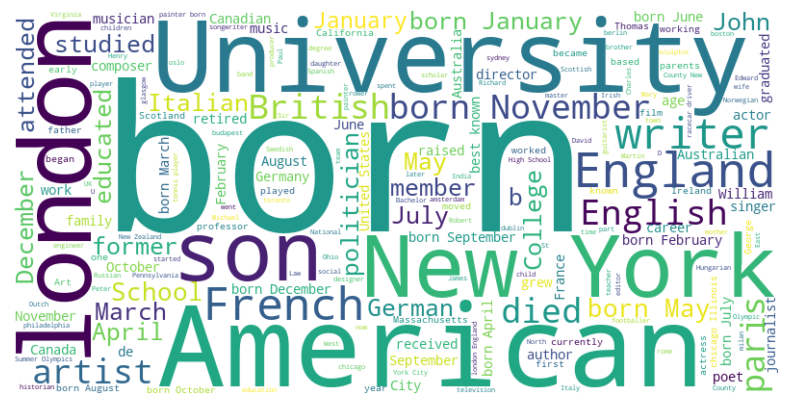

In [23]:
# Concatenate text data from the column
text_data = ' '.join(google_placeBirth['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

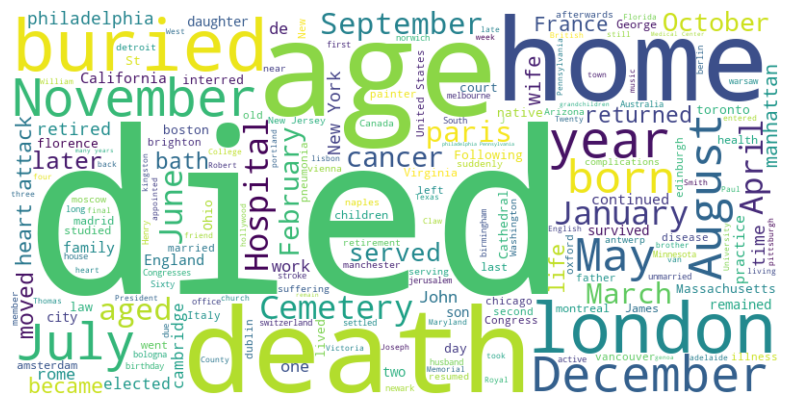

In [24]:
# Concatenate text data from the column
text_data = ' '.join(google_placeDeath['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

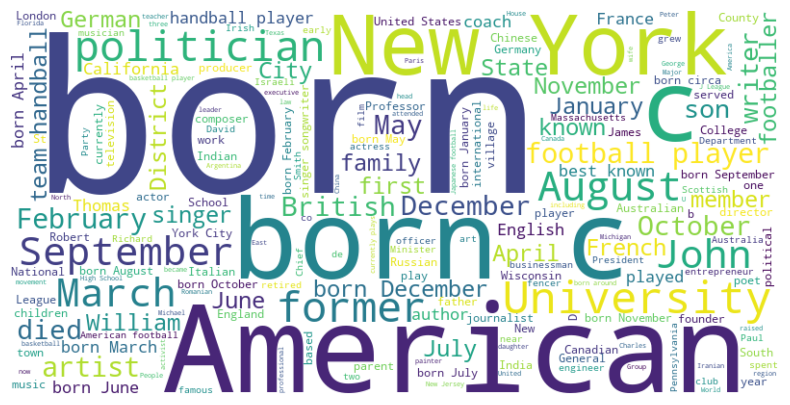

In [25]:
# Concatenate text data from the column
text_data = ' '.join(google_dataBirth['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

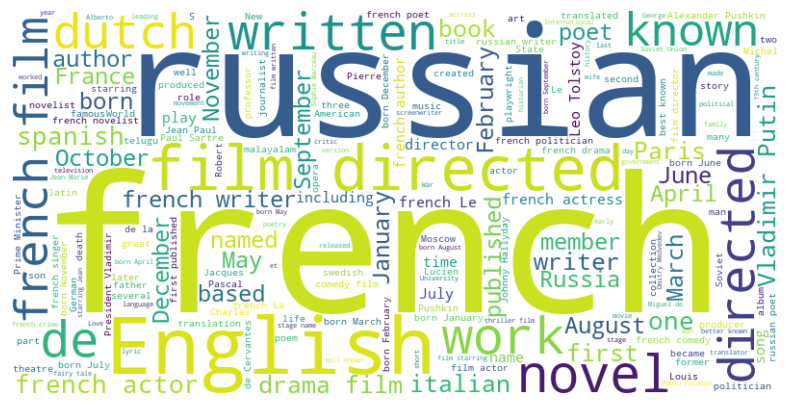

In [26]:
# Concatenate text data from the column
text_data = ' '.join(language['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

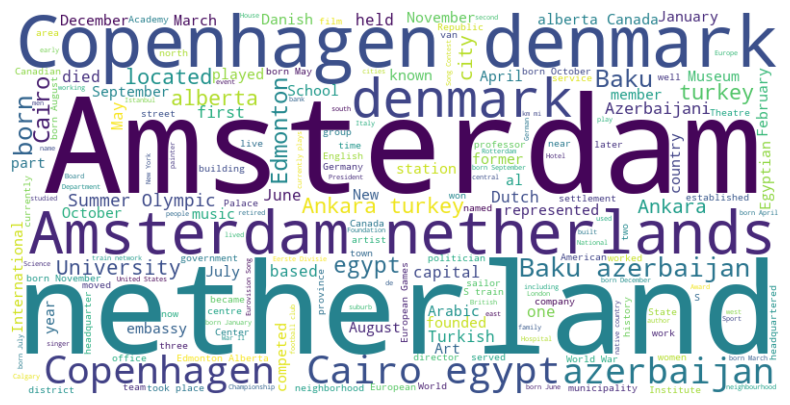

In [27]:
# Concatenate text data from the column
text_data = ' '.join(capital['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

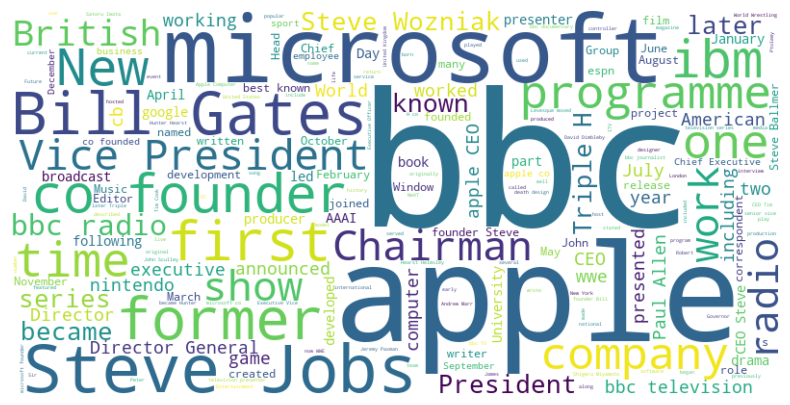

In [28]:
# Concatenate text data from the column
text_data = ' '.join(worksfor['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

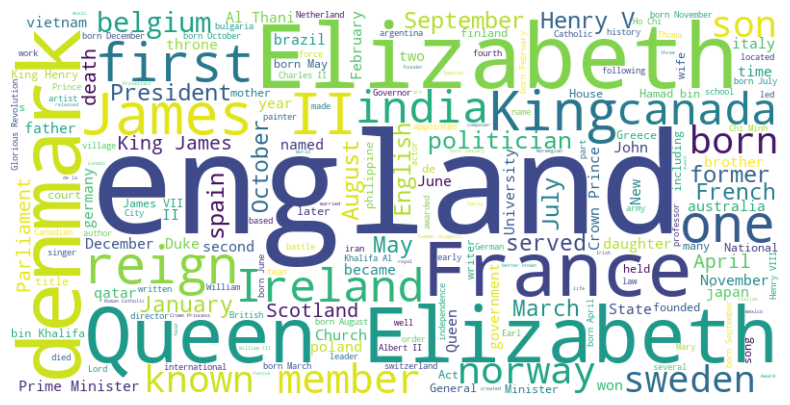

In [29]:
# Concatenate text data from the column
text_data = ' '.join(citizen['filled_sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenize the text into words
words = text_data.lower().split()

# Count the frequency of each word
word_freq = Counter(words)

# Sort by frequency in descending order
top_words = word_freq.most_common(10)

# Extract words and frequencies for plotting
words = [pair[0] for pair in top_words]
frequencies = [pair[1] for pair in top_words]

# Plotting the bar plot
fig = go.Figure(data=[go.Bar(x=words, y=frequencies)])

fig.update_layout(title='Frequency of Words in Text',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()